In [1]:
% load_ext autoreload
% autoreload 2

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import sys
sys.path.append('..')
from src.evaluation.evaluator import Evaluator
from src.datasets import SyntheticDataGenerator, MultivariateAnomalyFunction
import main

c:\users\thomas\python\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TODO:
- XOR (Anomaly -> gleichzeitig)
- Ableitung (Geschwindigkeit vs Beschleunigung)
- Invers

## Plot missing results

In [46]:
datasets = [SyntheticDataGenerator.get(f'extreme_1_missing', 42, missing) for missing in np.linspace(0, 0.9, 2)]
detectors = main.get_detectors()[:1] + main.get_detectors()[:0]

In [52]:
seeds = np.random.randint(low=0, high=2 ** 32 - 1, size=10, dtype="uint32")
print_order = ["dataset", "algorithm", "accuracy", "precision", "recall", "F1-score", "F0.1-score", "auroc"]
rename_columns = [col for col in print_order if col not in ['dataset', 'algorithm']]
results = pd.DataFrame()

for i, seed in enumerate(seeds):
    evaluator = Evaluator(datasets if datasets else get_pipeline_datasets(seed), detectors, seed=seed)
    evaluator.evaluate()
    result = evaluator.benchmarks()
    evaluator.benchmark_results = result
    evaluator.export_results(f'missing-run-{i}-{seed}', prefix='..')
    del evaluator  # Save memory
    results = results.append(result, ignore_index=True)

N/A% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

2018-07-05 16:18:03 [INFO] src.evaluation.evaluator: Training Recurrent EBM on Syn Extreme Outliers (mis=0.0) with seed 1800018548


KeyboardInterrupt: 

In [50]:
avg_results = results.groupby(["dataset", "algorithm"], as_index=False).mean()
std_results = results.groupby(["dataset", "algorithm"], as_index=False).std()

print(avg_results)

evaluator = Evaluator(datasets if datasets else get_pipeline_datasets(seed), detectors, seed=42)
evaluator.benchmark_results = avg_results

In [60]:
print(f'{"-"*20} Average {"-"*20}')
print(avg_results)
print(f'{"-"*22} Std {"-"*22}')
print(std_results)

-------------------- Average --------------------
                          dataset      algorithm  accuracy  precision  recall  \
0  Syn Extreme Outliers (mis=0.0)  Recurrent EBM  0.988222   1.000000    0.47   
1  Syn Extreme Outliers (mis=0.9)  Recurrent EBM  0.986556   0.984211    0.41   

   F1-score  F0.1-score     auroc  
0  0.625227    0.985021  0.876778  
1  0.552246    0.964077  0.880222  
---------------------- Std ----------------------


In [51]:
path = evaluator.export_results('missing-final', prefix='..')

2018-07-05 16:17:40 [INFO] src.evaluation.evaluator: Store evaluator results at C:\Users\Thomas\HPI\MP\reports\evaluators\run-pipeline-2018-07-05-161740.pkl


In [53]:
evaluator2 = Evaluator(datasets, detectors)
evaluator2.import_results(path[:-4], prefix='..')

2018-07-05 16:18:25 [INFO] src.evaluation.evaluator: Read evaluator results at C:\Users\Thomas\HPI\MP\reports\evaluators\run-pipeline-2018-07-05-161740.pkl


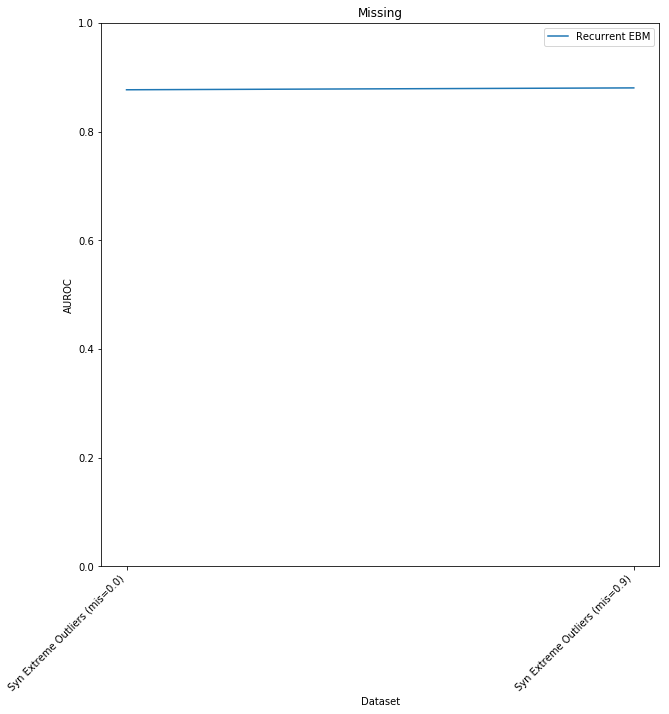

In [55]:
fig = evaluator2.plot_experiment_comparison('Missing')

### For the presentation

(-4.3500000000000005, 91.35, -0.19781476007338059, 4.154109961540992)

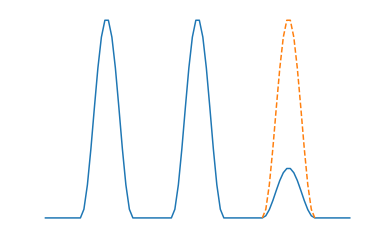

In [13]:
def get_curve(length, amplitude):
    # Transformed sinus curve: [-1, 1] -> [0, amplitude]
    def curve(t: int):
        return amplitude * (np.sin(t)/2 + 0.5)
    # Start and end of one curve section in sinus
    from_ = 1.5 * np.pi
    to_ = 3.5 * np.pi
    return np.array([curve(t) for t in np.linspace(from_, to_, length)])

timeline = np.concatenate([np.zeros(10), get_curve(16, 4), np.zeros(10), get_curve(16, 4), np.zeros(10)])
plt.plot(np.concatenate([timeline, get_curve(16, 1), np.zeros(10)]))
plt.plot(np.concatenate([[None]*len(timeline), get_curve(16, 4), [None]*10]), '--')
plt.axis('off')

(-4.3500000000000005, 91.35, -0.19781476007338059, 4.154109961540992)

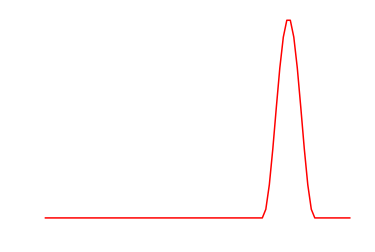

In [14]:
plt.plot(np.concatenate([[0]*len(timeline), get_curve(16, 4), [0]*10]), 'r')
plt.axis('off')